## Concordance investigation

This file is part of the Glaucoma Phenotype ML Estimation project.

 Glaucoma Phenotype ML Estimation is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.


The Glaucoma Phenotype ML Estimation project is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with the Glaucoma Phenotype ML Estimation project.  If not, see <http://www.gnu.org/licenses/>.


This notebook investigates the concordance relations between the various graders within this dataset, this sets a lower bound for minimum error 

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pickle as pkl
import os
from pathlib import Path
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import zipfile
#import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from glaucoma.helpers.glaucoma_helpers import is_number, parse_files, return_uniq_index, return_duplicates, plot_idx, split_unzipped
from sklearn.metrics import cohen_kappa_score

In [14]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)


In [15]:
##### PLEASE SET AS REQUIRED########
WORKING_DIR = Path(os.getcwd())
DATA_DIR = WORKING_DIR / 'data'
META_DIR = DATA_DIR / 'metadata'
TRAIN_DIR = DATA_DIR /"traim"

In [16]:
unzipped_files = parse_files(str(DATA_DIR / "unzipped"))

In [11]:
# split up unzipped files
unzipped_head, unzipped_tail = split_unzipped(unzipped_files)

## Preprocessing

Split the files based on each rater

In [8]:
meta_files = parse_files(str(META_DIR))

In [9]:
v1_meta =[i for i in meta_files if not "V2" in i]
v2_meta = [i for i in meta_files if "V2" in i]

In [10]:
meta_df_list =[]
for meta in v1_meta:
    df = pd.read_csv(meta,sep = '\t',header = None,names = [ "file_name","assesment"])
    df['batch_name'] = os.path.split(meta)[1].split(".")[0]
    meta_df_list.append(df)


In [11]:
meta_v2_df_list =[]
for meta in v2_meta:
    df = pd.read_csv(meta,sep = '\t',header = None,names = [ "file_name","area","col1","col2"])
    df['batch_name'] = os.path.split(meta)[1].split(".")[0]
    meta_v2_df_list.append(df)

In [12]:
meta_df = pd.concat(meta_df_list,ignore_index =True)

In [13]:
meta_v2_df = pd.concat(meta_v2_df_list,ignore_index =True)

In [14]:
#split up assesment
meta_df[['additional','grading']] = meta_df['assesment'].str.extract('([A-Za-z]+)(\d+\.?\d*)', expand = True)


In [15]:
#drop all NA assesments
meta_df = meta_df[meta_df['assesment'].notna()]

In [16]:
#adds all the gradings from assesment
meta_df.loc[meta_df['grading'].isnull(),"grading"] = meta_df.loc[meta_df['grading'].isnull(),"assesment"]

In [18]:
assesments = list(meta_df['assesment'])

In [19]:
# take out the string values and replaces then with -1
for i,item in enumerate(assesments):
    if any(map(str.isdigit, item)) == False:
        meta_df.iloc[i,4] = -1
        meta_df.iloc[i,3] = meta_df.iloc[i,1]
        
    

In [159]:
#adding name of grader

In [24]:
batch_names = list(meta_df["batch_name"])

In [26]:
meta_df["grader"] = "null"

In [22]:
len(batch_names)

101077

In [27]:
###### CHANGE THESE AS REQUIRED########
# rater names
rater_1 = ""
rater_2 = ""
rater_3

for i, bn in enumerate(batch_names):
    if rater_1 in bn:
        meta_df.iloc[i,5] = rater_1
    if rater_2 in bn:
        meta_df.iloc[i,5] = rater_2
    if rater_3 in bn:
        meta_df.iloc[i,5] = rater_3
        

In [28]:
meta_df.drop_duplicates(inplace = True)

In [29]:
#change grading to float
meta_df["grading"] = meta_df["grading"].astype("float")

In [30]:
# Fixing the strange samples:

In [31]:
meta_df.loc[meta_df["grading"] == 77.5,"grading"] = 7.5
meta_df.loc[meta_df["grading"] == 2.52,"grading"] = 2.5
meta_df.loc[meta_df["grading"] == 7.57,"grading"] = 7.5
meta_df.loc[meta_df["grading"] == 6.55,"grading"] = 2.5

In [32]:
unknown_samples = meta_df[(meta_df["grading"] % 0.5 != 0) | (meta_df["grading"] > 10)].copy(deep=True)

In [33]:
#drop unknown samples
meta_df = meta_df[~(meta_df["grading"] % 0.5 != 0) & ~(meta_df["grading"] > 10)]

In [ ]:
# adding left and right tag to eye:
meta_df["orientation"] = 'left'
for i, bn in enumerate(batch_names):
    if "Right" in bn:
         meta_df.iloc[i,6] = "right"
        

In [12]:
#save out metafile
meta_df = pkl.load(open(str(DATA_DIR /"meta_df_v5.pkl"),'rb'))

In [13]:
image_groupby = meta_df.groupby("file_name")

In [14]:
image_groupby = meta_df.groupby("file_name")["grading"].agg(['mean','count',"var"])

In [18]:
#samples which have been graded twice with same values that were not ungradable
repeated_images = image_groupby[(image_groupby["var"] > 0) & (image_groupby["count"] > 1)].index
#repeated_images = list(repeated_images)

In [ ]:
meta_df[meta_df["file_name"] == '3044056_21015_0_0.jpg']

In [26]:
multi_rated = list(image_groupby[image_groupby["count"] > 18].index)

In [17]:
#images which have gradings from different peope=le
different_grader_images = []
for file in repeated_images:
    if len( meta_df[meta_df["file_name"] == file]['grader'].unique()) > 1 and -1 not in list(meta_df[meta_df["file_name"] == file]['grading']):
        different_grader_images.append(file)

In [101]:
len(different_grader_images)

3373

In [72]:
meta_df[meta_df["file_name"] == '1006584_21015_1_0.jpg']

,file_name,assesment,batch_name,additional,grading,grader
17368,1006584_21015_1_0.jpg,4.5,L_87_jamie1,NaN,4.5,jamie
18378,1006584_21015_1_0.jpg,5,L_87_NickAndrew,NaN,5.0,nick


In [102]:
#find the difference across graders
image_dfs = {}
data_1 =[]
data_2 = []
data_3 = []
for file in different_grader_images:
    df = meta_df[meta_df["file_name"] == file]
    group_by = df.groupby("grader").agg(['mean','count',"var"])
    #check that it is graded by both
    if rater_1 in group_by.index and rater_2 in group_by.index:
        data_2.append(group_by['grading'].loc[rater_2,'mean'])
        data_1.append(group_by['grading'].loc[rater_1,'mean'])
    else:
        data_3.append(file)
    image_dfs[file] = group_by

In [103]:
len(data_2)

2199

In [104]:
len(data_3)

1174

## Bland Atman plot

In [79]:
import pyCompare

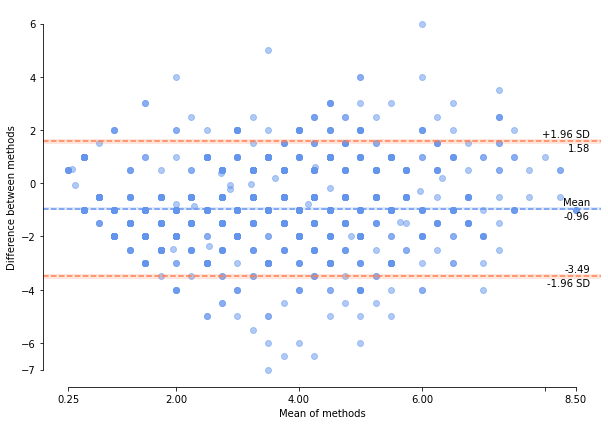

In [111]:
pyCompare.blandAltman(data_2, data_1,
            limitOfAgreement=1.96,
            confidenceInterval=95,
            confidenceIntervalMethod='approximate',
            detrend=None,
            percentage=False)

### Pearson

In [113]:
from scipy.stats import pearsonr

In [114]:
pearsonr(data_2,data_1)

(0.6698250808949919, 2.2346796660924033e-286)

In [170]:
unzipped_tail = np.asarray(unzipped_tail)

In [183]:
def print_all_img(img):
    list_idx = np.where(unzipped_tail == img )[0]
    for idx in list_idx:
        print(idx)
        img=mpimg.imread(unzipped_files[idx])
        imgplot = plt.imshow(img)
        plt.show()

## individual rating distributions

In [133]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [136]:
grads_1 = list(meta_df[(meta_df["grader"] == rater_1) & (meta_df["grading"] >=0)]["grading"])
grads_2 = list(meta_df[(meta_df["grader"] == rater_2) & (meta_df["grading"] >=0)]["grading"])
grads_3 = list(meta_df[(meta_df["grader"] == rater_3) & (meta_df["grading"] >=0)]["grading"])

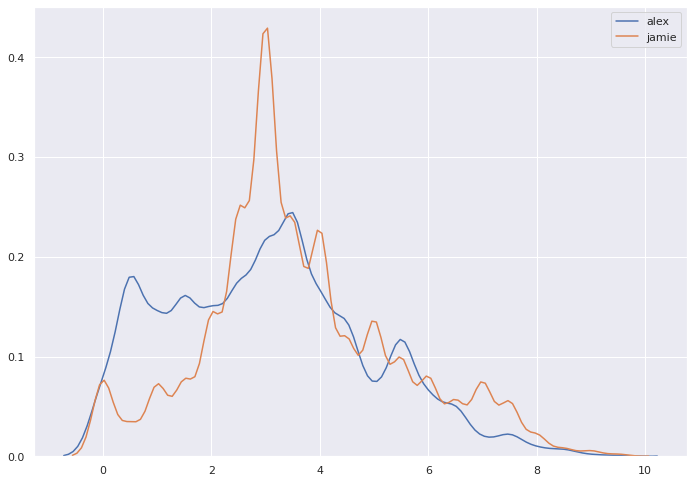

In [137]:
sns.distplot(grads_2,hist= False,label = rater_2)
sns.distplot(grads_1,hist = False,label  = rater_1)

## Intra -rater consistancy

In [30]:
from nltk import agreement

In [ ]:
person = rater_2
sets = []
for file in multi_rated:
    df = meta_df[meta_df["file_name"] == file]
    df = df[df['grader'] == person].iloc[:7,:]
    print(df.shape)
    sets.append(list(df["grading"]))
        

In [156]:
import pingouin as pg
# package required


In [178]:
icc_set = meta_df[(meta_df["file_name"].isin(multi_rated))& (meta_df["grader"] == rater_2)]

In [179]:
pg.intraclass_corr(data = icc_set,targets ="file_name",raters = "grader",ratings = "grading",nan_policy = 'omit')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,NaN,NaN,19,0,NaN,"[nan, nan]"
1,ICC2,Single random raters,NaN,NaN,19,0,NaN,"[nan, nan]"
2,ICC3,Single fixed raters,NaN,NaN,19,0,NaN,"[nan, nan]"
3,ICC1k,Average raters absolute,NaN,NaN,19,0,NaN,"[nan, nan]"
4,ICC2k,Average random raters,NaN,NaN,19,0,NaN,"[nan, nan]"
5,ICC3k,Average fixed raters,NaN,NaN,19,0,NaN,"[nan, nan]"


In [144]:
statsmodels.stats.inter_rater.fleiss_kappa(mat,method ='fleiss')

0.35173251144111334

In [148]:
from collections import Counter

In [149]:
counts = []
for i in sets:
    counts.append(Counter(i))
    

In [151]:
mat =np.zeros((20,21))
for i,c in enumerate(counts):
    for k,v in c.items():
        idx = int((float(k)+ 1) * 2)
        #print(idx," ",i)
        mat[i,idx] = v
        
    

In [153]:
fleiss_kappa(mat)

0.28133020868206676

In [74]:
def fleiss_kappa(M):
    """
    See `Fleiss' Kappa <https://en.wikipedia.org/wiki/Fleiss%27_kappa>`_.
    :param M: a matrix of shape (:attr:`N`, :attr:`k`) where `N` is the number of subjects and `k` is the number of categories into which assignments are made. `M[i, j]` represent the number of raters who assigned the `i`th subject to the `j`th category.
    :type M: numpy matrix
    """
    N, k = M.shape  # N is # of items, k is # of categories
    n_annotators = float(np.sum(M[0, :]))  # # of annotators

    p = np.sum(M, axis=0) / (N * n_annotators)
    P = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
    Pbar = np.sum(P) / N
    PbarE = np.sum(p * p)

    kappa = (Pbar - PbarE) / (1 - PbarE)

    return kappa